Data

https://www.kaggle.com/competitions/dogs-vs-cats/data

In [ ]:
import os
import numpy as np

In [ ]:
images = os.listdir('./data/train/')

In [ ]:
images[0]

In [ ]:
cats = [image for image in images if 'cat' in image]
dogs = [image for image in images if 'dog' in image]

In [ ]:
print('Cats: {}'.format(len(cats)))
print('Dogs: {}'.format(len(dogs)))

In [ ]:
os.makedirs('./data/train/cats')
os.makedirs('./data/train/dogs')

In [ ]:
for cat in cats:
    os.replace(f'./data/train/{cat}', f'./data/train/cats/{cat}')

In [ ]:
for dog in dogs:
    os.replace(f'./data/train/{dog}', f'./data/train/dogs/{dog}')

In [ ]:
for dog in os.listdir('./data/train/dogs'):
    ndog = dog.replace('dog.', '')
    os.replace(f'./data/train/dogs/{dog}', f'./data/train/dogs/{ndog}')

In [ ]:
for dog in os.listdir('./data/train/cats'):
    ndog = dog.replace('cat.', '')
    os.replace(f'./data/train/cats/{dog}', f'./data/train/cats/{ndog}')

In [ ]:
import cv2
img = cv2.imread('./data/train/cats/0.jpg')


In [ ]:
img.shape

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
img_size = (180, 180)
batch_size = 32

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './data/train',
    validation_split=0.2,
    subset='training',
    seed=1337,
    image_size=img_size,
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './data/train',
    validation_split=0.2,
    subset='validation',
    seed=1337,
    image_size=img_size,
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


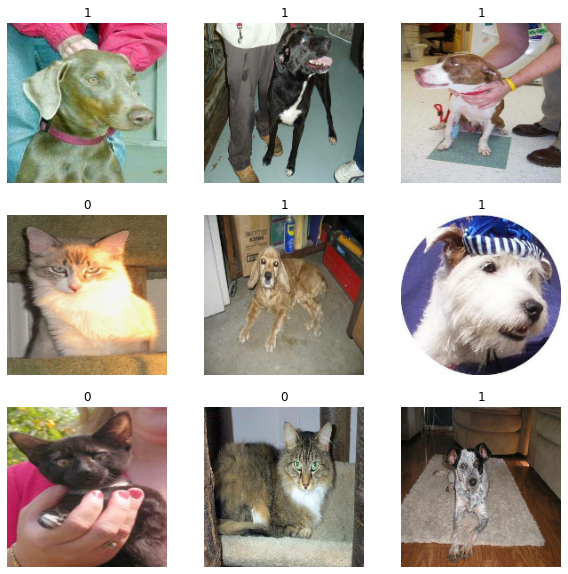

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(int(labels[i]))
        plt.axis('off')

In [8]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1)
])

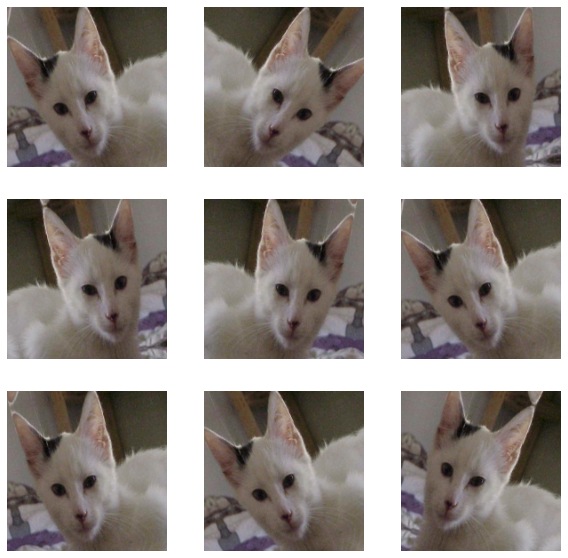

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

In [8]:
# def make_model(input_shape, num_classes):
#     inputs = keras.Input(shape=input_shape)
#     x = data_augmentation(inputs)

#     # Entry Block
#     x = layers.Rescaling(1.0 / 255)(x)
#     x = layers.Conv2D(32, 3, strides=2, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')

#     x = layers.Conv2D(64, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)

#     previsous_block_activation = x

#     for size in [128, 256, 512, 728]:
#         x = layers.Conv2D(size, 3, padding='same')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation('relu')(x)

#         x = layers.Conv2D(size, 3, padding='same')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation('relu')(x)

#         x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

#         # Project Residual
#         residual = layers.Conv2D(size, 1, strides=2, padding='same')(previsous_block_activation)
#         x = layers.add([x, residual])
#         previsous_block_activation = x

#     x = layers.Conv2D(1024, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.GlobalAveragePooling2D()(x)
#     if num_classes == 2:
#         activation = 'sigmoid'
#         units = 1
#     else:
#         activation = 'softmax'
#         units = num_classes

#     x = layers.Dropout(0.5)(x)
#     outputs = layers.Dense(units, activation=activation)(x)
#     return keras.Model(inputs, outputs)

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Conv2D(size, 3, padding="same")(x)
        x = layers.Activation("relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Conv2D(size, 3, padding="same")(x)
        x = layers.Activation("relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.Conv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [11]:
model = make_model(input_shape=img_size + (3,), num_classes=2)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 32)   896         ['rescaling[0][0]']          

In [13]:
keras.utils.plot_model(model, show_shapes=True)

"dot" with args ['-Tps', 'C:\\Users\\GUILHE~1.ANG\\AppData\\Local\\Temp\\tmpupz85xxo'] returned code: 1

stdout, stderr:
 b''
b'Format: "ps" not recognized. Use one of:\r\n'



AssertionError: "dot" with args ['-Tps', 'C:\\Users\\GUILHE~1.ANG\\AppData\\Local\\Temp\\tmpupz85xxo'] returned code: 1

In [18]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
  2/625 [..............................] - ETA: 3:42:19 - loss: 2.1975 - accuracy: 0.4688

KeyboardInterrupt: 